**COURSE: PRDL/MLLB**

**PROJECT: Deep Learning**

**TEACHER: Luis Hernández Gómez**

**AUTHORS: MARONE Mamadou / RACHIDI Inass**

**NOTEBOOK: PRETRAINED BERT (TRANSFER LEARNING & FINETUNING)**

# SETUP

## INSTALLING MODULES

In [ ]:
%%capture
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.15.*"
!pip install "tf-models-official==2.15.*"

## IMPORTING LIBRARIES

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

## LOAD & PREPARE THE DATA

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving processed_data.csv to processed_data.csv
User uploaded file "processed_data.csv" with length 36192361 bytes


In [ ]:
df_cat = pd.read_csv("processed_data.csv")
df_cat.head(-1)

,category,title,body,text
0,ARTS & CULTURE,modeling agencies enabled sexual predators yea...,october 2017 carolyn kramer received disturbin...,modeling agencies enabled sexual predators yea...
1,ARTS & CULTURE,actor jeff hiller talks bright colors bold pat...,week talked actor jeff hiller hit broadway pla...,actor jeff hiller talks bright colors bold pat...
2,ARTS & CULTURE,new yorker cover puts trump hole racist comment,new yorker taking president donald trump asked...,new yorker cover puts trump hole racist commen...
3,ARTS & CULTURE,man surprises girlfriend drawing different ani...,kellen hickey 26 year old lives hudson wiscons...,man surprises girlfriend drawing different ani...
4,ARTS & CULTURE,artist gives renaissance style sculptures goof...,something combining traditional uptight look r...,artist gives renaissance style sculptures goof...
...,...,...,...,...
6866,WOMEN,women run,listened kathrine switzer describe preparation...,women run listened kathrine switzer describe p...
6867,WOMEN,casually fearless millennials natural entrepre...,still think tuesday night dinner 22 year old d...,casually fearless millennials natural entrepre...
6868,WOMEN,happy birthday us,remember morning high school graduation clearl...,happy birthday us remember morning high school...
6869,WOMEN,culture love,husband gene wear pajamas asked told never paj...,culture love husband gene wear pajamas asked t...


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(df_cat['text'], df_cat['category'], test_size=0.2, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Importing the pretarined BERT model

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check TensorFlow Hub version
import tensorflow_hub as hub
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.15.0
TensorFlow Hub version: 0.15.0


# FINETUNING

## build the model

In [ ]:
# Define your model
def build_classifier_model(finetuned):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=finetuned, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
# Build and compile the model
classifier_model_finetuned = build_classifier_model(True)

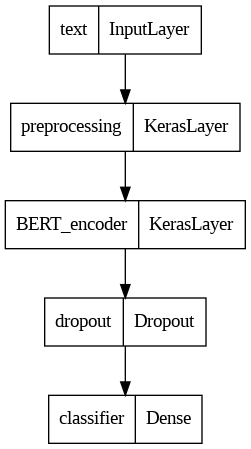

In [ ]:
tf.keras.utils.plot_model(classifier_model_finetuned)

## Parameters setting

### Loss Function:

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

### Training parameters

In [ ]:
epochs = 5
BATCH_SIZE = 32
steps_per_epoch = 985 # 625
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Compile the model

In [ ]:
classifier_model_finetuned.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## TRAINING

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_finetuned.fit(train_data , train_labels_encoded,
                              validation_split=0.1,
                              batch_size=BATCH_SIZE,
                              epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
155/155 [==============================] - 66s 285ms/step - loss: 2.5350 - accuracy: 0.1910 - val_loss: 1.9325 - val_accuracy: 0.4055
Epoch 2/5
155/155 [==============================] - 40s 260ms/step - loss: 1.4082 - accuracy: 0.5975 - val_loss: 0.9019 - val_accuracy: 0.7309
Epoch 3/5
155/155 [==============================] - 40s 259ms/step - loss: 0.8372 - accuracy: 0.7409 - val_loss: 0.7689 - val_accuracy: 0.7582
Epoch 4/5
155/155 [==============================] - 44s 285ms/step - loss: 0.6327 - accuracy: 0.7987 - val_loss: 0.7050 - val_accuracy: 0.7764
Epoch 5/5
155/155 [==============================] - 41s 266ms/step - loss: 0.4508 - accuracy: 0.8579 - val_loss: 0.7044 - val_accuracy: 0.7727


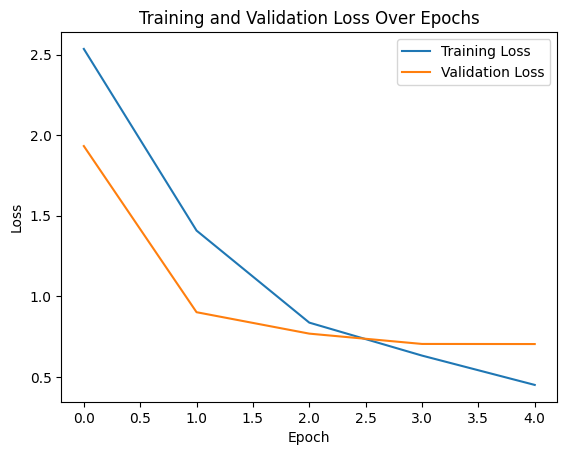

In [ ]:
# Plot training , testing and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## EVALUATION

In [ ]:
loss, accuracy = classifier_model_finetuned.evaluate(test_data , test_labels_encoded)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Evaluate the model on the test set
y_pred = classifier_model_finetuned.predict_classes(test_data)

# Calculate additional metrics
accuracy = accuracy_score(test_labels_encoded, y_pred)
conf_matrix = confusion_matrix(test_labels_encoded, y_pred)
classification_rep = classification_report(test_labels_encoded, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

# Extract precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels_encoded, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1_score)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Better FINETUNING

## Build the model

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Additional dense layers with batch normalization
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)

    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)

    # Output layer
    net = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax', name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
# Build and compile the model
classifier_model = build_classifier_model()

## Parameters setting

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

In [ ]:
epochs = 10
BATCH_SIZE = 32
steps_per_epoch = 985
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## TRAINING

In [ ]:
train_labels_encoded
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(train_data , train_labels_encoded,
                              validation_split=0.1,
                              batch_size=BATCH_SIZE,
                              epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
155/155 [==============================] - 51s 283ms/step - loss: 3.3794 - accuracy: 0.0784 - val_loss: 2.6145 - val_accuracy: 0.1109
Epoch 2/5
155/155 [==============================] - 41s 263ms/step - loss: 3.2171 - accuracy: 0.0887 - val_loss: 2.3769 - val_accuracy: 0.1509
Epoch 3/5
155/155 [==============================] - 41s 266ms/step - loss: 2.6218 - accuracy: 0.2098 - val_loss: 1.7784 - val_accuracy: 0.4255
Epoch 4/5
155/155 [==============================] - 42s 269ms/step - loss: 1.8895 - accuracy: 0.4079 - val_loss: 1.1872 - val_accuracy: 0.6782
Epoch 5/5
155/155 [==============================] - 41s 264ms/step - loss: 1.4216 - accuracy: 0.5729 - val_loss: 1.0100 - val_accuracy: 0.7145


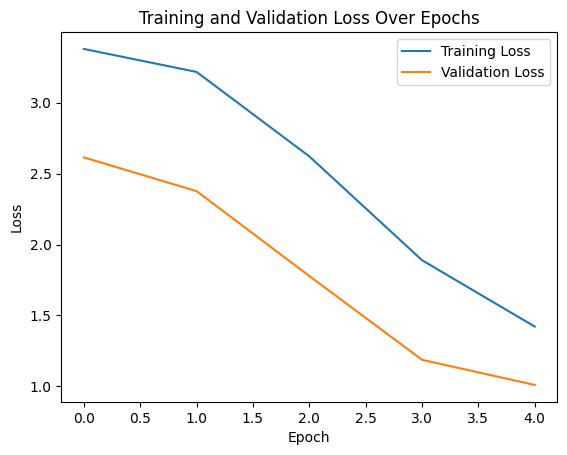

In [ ]:
# Plot training , testing and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## EVALUATION

In [ ]:
test_loss, test_accuracy = classifier_model.evaluate(test_data, test_labels_encoded)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

43/43 [==============================] - 6s 150ms/step - loss: 0.9668 - accuracy: 0.7135

Test Accuracy: 71.35%


In [ ]:
# Evaluate the model on the test set
y_pred = classifier_model.predict_classes(test_data)

# Calculate additional metrics
accuracy = accuracy_score(test_labels_encoded, y_pred)
conf_matrix = confusion_matrix(test_labels_encoded, y_pred)
classification_rep = classification_report(test_labels_encoded, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

# Extract precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels_encoded, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1_score)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Transfer Learning

## Build the model

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Additional dense layers with batch normalization
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)

    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)

    # Output layer
    net = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax', name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
# Build and compile the model
classifier_model_transf = build_classifier_model()

### Parameter setting 

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

In [ ]:
epochs = 10
BATCH_SIZE = 32
steps_per_epoch = 985
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model_transf.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## TRAINING

In [ ]:
train_labels_encoded
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_transf.fit(train_data , train_labels_encoded,
                              validation_split=0.1,
                              batch_size=BATCH_SIZE,
                              epochs=epochs)

In [ ]:
# Plot training , testing and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## EVALUATION

In [ ]:
test_loss, test_accuracy = classifier_model_transf.evaluate(test_data, test_labels_encoded)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Evaluate the model on the test set
y_pred = classifier_model_transf.predict_classes(test_data)

# Calculate additional metrics
accuracy = accuracy_score(test_labels_encoded, y_pred)
conf_matrix = confusion_matrix(test_labels_encoded, y_pred)
classification_rep = classification_report(test_labels_encoded, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

# Extract precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels_encoded, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1_score)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Export for inference

In [ ]:
dataset_name = 'article'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
text = "integration digital tools online resources transformed way students learn, providing new opportunities interactive personalized learning experiences. Educational institutions adapting curricula include coding classes, virtual labs, collaborative projects prepare students evolving demands digital age."

text_tensor = tf.constant([text])

# Make predictions using the loaded model
prediction = reloaded_model(text_tensor)

# Convert the prediction to a numpy array
prediction_array = np.array(prediction)

# Assuming it's a single-label classification task
predicted_label = np.argmax(prediction_array)

predicted_category = label_encoder.inverse_transform([predicted_label])[0]

# Print the predicted label
print(f"The predicted category for the text is: {predicted_category}")

The predicted category for the text is: EDUCATION
